### Solving the RTE

We define and solve an RTE. This builds off the MakeOpticalProperties tutorial. We do not render radiances here.

As `at3d` is focused on retrieval problems it is natural to take the 'sensor first' workflow that is required for inverse problems even in the forward problem. That workflow is covered in another tutorial. In this case we are just familiarizing ourselves with the `solver.RTE` object and its required inputs and available outputs which we will visualize.


In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import os
import importlib

In [2]:
# make the optical properties
cloud_scatterer = at3d.util.load_from_csv(os.path.join(importlib.resources.files('at3d'),'data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'), density='lwc', origin=(0.0,0.0))


### Choosing the RTE grid.

While this was brushed over in the optical property tutorial, the choice of the RTE grid is critical for the SHDOM solution. 

There are two grids in SHDOM, the property grid and the RTE grid. The property grid is the grid for the input optical properties and is a regular grid that is also equispaced in the horizontal. The RTE grid is an adaptive grid. However, its initial base grid is also regular and equispaced in the horizontal.

In many applications the base RTE grid is also the property grid. But in some cases, one may want to represent the medium coarsely while still solving the RTE at high spatial resolution. This is particularly useful in the inverse problem. As such, the `make_grid` function has **optional** arguments for the number of RTE base grid points which will make the RTE base grid different to the property grid.

In [3]:
# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z)
rte_grid

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02

In [22]:
# define the property grid - and also the base RTE grid
rte_grid2 = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z, nx=32, ny=37)
rte_grid2

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02

### Make the Optical Properties

The grid information is contained in each set of microphysical and optical properties. For this reason, resampling data onto the `rte_grid` is generally required as it is the easiest way to make sure each scattering species has the correct accompanying information. Note that all of the `pyshdom` processing propagates these variables. If you want to write your own interpolation methods or other schemes, this should be taken into account.

In [23]:
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

In [24]:

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))
# mie property
mie_mono_table = at3d.mie.get_mono_table(
    'Water',(0.86,0.86),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)
mie_mono_tables = OrderedDict()
mie_mono_tables[0.86] = mie_mono_table
# optical property generator
optical_prop_gen = at3d.medium.OpticalPropertyGenerator(
    'cloud',
    mie_mono_tables, 
    size_distribution_function,
    particle_density=1.0, 
    maxnphase=None,
    interpolation_mode='exact', 
    reff=np.linspace(10,30.0,20),
    veff=np.linspace(0.01,0.2,5)
)
# optical properties, for simplicity, only at one wavelength.
optical_properties = optical_prop_gen(cloud_scatterer_on_rte_grid)[0.86]
optical_properties

<xarray.Dataset>
Dimensions:        (legendre_index: 1017, num_micro: 1, stokes_index: 6, table_index: 22, x: 32, y: 37, z: 26)
Coordinates:
    table_index    (num_micro, x, y, z) int64 1 1 1 1 2 3 ... 18 19 20 21 22 22
  * stokes_index   (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * x              (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y              (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z              (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.32 1.36 1.4 1.44
    reff           (x, y, z) float64 11.69 11.69 11.69 11.69 ... 18.57 18.7 18.7
    veff           (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
Dimensions without coordinates: legendre_index, num_micro
Data variables:
    extinction     (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ssalb          (x, y, z) float64 1.0 1.0 1.0 1.0 ... 0.9999 0.9999 0.9999
    legcoef        (stokes_index, legendre_index, table_index) float32 1.0 .....
    phase_weights  (num_micro, x, y, z) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    density        (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    delx           float64 0.02
    dely           float64 0.02
    interp_method  <U5 'exact'
Attributes:
    distribution_type:           gamma
    radius_units:                radius units [micron]
    particle_type:               Water
    refractive_index:            [ 1.33000004e+00 -2.89324419e-07]
    refractive_index_source:     src/polarized/indexwatice.f
    units:                       ['Radius [micron]', 'Wavelength [micron]']
    wavelength_band:             [0.86 0.86]
    wavelength_center:           0.8600000143051147
    wavelength_averaging:        False
    wavelength_resolution:       0.001
    maximum_legendre:            1016
    minimum_effective_radius:    0.1
    maximum_integration_radius:  65.0
    density_name:                lwc
    file_name:                   ../data/synthetic_cloud_fields/jpl_les/rico3...

### Numerical Parameters

The SHDOM method has a large number of numerical parameteres that control its accuracy, but also which allow optimized memory management which may be necessary given the large memory requirement of the method. The numerical parameters also contain the settings for the horizontal boundary conditions and the mode of radiative transfer 1D/2D/3D etc.

For simplicity, `default_config.json` within the distribution contains a set of defaults that are appropriate for solar radiative transfer and err on the side of too much memory. This means that too much memory may be allocated at the convenience of not having to increase the memory parameters due to running out. No spherical harmonic truncation is employed.

Users should read the descriptions in `default_config.json` and in `shdom.txt` to familiarize themselves with these parameters. Note that many of the parameters are absolute values and so will need to be wavelength dependent for thermal sources or to vary with the magnitude of the specified solarflux as mentioned below.

With a deterministic solver like SHDOM, the correct way to estimate the accuracy of the solution is with a convergence test, ie running the solver at higher resolution until the quantities don't appreciably change compared to a tolerance that is appropriate for your scientific investigation.

In [3]:
config = at3d.configuration.get_config('../default_config.json')
config['max_total_mb'] = 1000.0
config['adapt_grid_factor'] = 2

In [4]:
config

<xarray.Dataset>
Dimensions:                       ()
Data variables: (12/20)
    x_boundary_condition          <U4 'open'
    y_boundary_condition          <U4 'open'
    num_mu_bins                   int64 16
    num_phi_bins                  int64 32
    split_accuracy                float64 0.03
    deltam                        bool True
    ...                            ...
    ip_flag                       int64 0
    iterfixsh                     int64 30
    tautol                        float64 0.1
    angle_set                     int64 2
    transcut                      float64 1e-05
    transmin                      float64 1.0

### Surfaces

A wide variety of surface BRDF schemes are implemented in SHDOM and hence in pyshdom. Each surface type has its own generator in `at3d.surface`. 

For this example we will use a spatially variable ocean surface. The spatial variations are defined by a grid spacing in the horizontal directions and the size of the array. This grid does not have to match the RTE grid. The properties will be linearly interpolated onto the RTE grid during the initialization of the solver.

Also note that a full surface BRDF is noticeably slower than a lambertian surface (try contrasting run time between the two). Bear this in mind if you are prototyping synthetic data with lambertian surfaces that realistic cases will be significantly more computationally expensive.


In [87]:
ocean_surface = at3d.surface.ocean_unpolarized(np.array([[5,10],[5,10]]), np.ones((2,2))*0.05, ground_temperature=298.15,
                      delx=0.7, dely=0.7)
lambertian_surface = at3d.surface.lambertian(0.05)
ocean_surface

<xarray.Dataset>
Dimensions:     (nparameters: 27)
Dimensions without coordinates: nparameters
Data variables:
    name        <U17 'ocean_unpolarized'
    sfctype     <U2 'VO'
    gndalbedo   float64 0.0
    gndtemp     float64 298.1
    maxsfcpars  int64 3
    nxsfc       int64 2
    nysfc       int64 2
    delxsfc     float64 0.7
    delysfc     float64 0.7
    nsfcpar     int64 3
    sfcparms    (nparameters) float32 298.1 5.0 0.05 298.1 ... 298.1 5.0 0.05

### Source Type

SHDOM supports a combination of collimated solar or blackbody thermal emission volume sources. It is also possible to set an isotropic downwelling radiance as the upper boundary condition. 

One must specify the magnitude of the solar flux and a monochromatic wavelength. Note that the monochromatic wavelength is only required for thermal sources or for surface BRDF schemes such as `ocean_unpolarized` which have a wavlength dependent model for ocean optical properties.

**NB Note that many of the numerical parameters above are absolute values, as such they should vary in concert with the magnitude of the source. For this reason it is best to leave** `solarflux=1.0` **for simplicity**.

Currently, band averaged sources is not supported by the python wrapper in `pyshdom.source` though it is supported by `solver.RTE` and the Fortran source.

In [88]:
source = at3d.source.solar(wavelength=0.86, solarmu=0.5, solar_azimuth=0.0, solarflux=1.0, skyrad=0.0)
source

<xarray.Dataset>
Dimensions:     (wavenumber: 2)
Coordinates:
  * wavenumber  (wavenumber) int64 10000 10001
Data variables:
    name        <U12 'solar_source'
    wavelength  float64 0.86
    solarflux   float64 1.0
    solarmu     float64 -0.5
    solaraz     float64 0.0
    srctype     <U1 'S'
    units       <U1 'R'
    skyrad      float64 0.0

### Initialize the Solver

There are currently no methods to safely overwrite properties in a solver ie, replace the optical properties or the surface while leaving all else unchanged. This is certainly possible but currently, a solver needs to be reinitialized instead.

In [89]:
solver = at3d.solver.RTE(numerical_params=config, medium={'cloud':optical_properties}, 
                   source=source, surface=ocean_surface, num_stokes=1, name=None,
                 atmosphere=None)

In [90]:
%%time
solver.solve(maxiter=100)

CPU times: user 4min 3s, sys: 868 ms, total: 4min 4s
Wall time: 4min 5s


In [91]:
solver = at3d.solver.RTE(numerical_params=config, medium={'cloud':optical_properties}, 
                   source=source, surface=lambertian_surface, num_stokes=1, name=None,
                 atmosphere=None)

In [92]:
%%time
solver.solve(maxiter=100)

CPU times: user 57.8 s, sys: 222 ms, total: 58 s
Wall time: 58.3 s


### Spherical Harmonic Output

We can access the normal spherical harmonic output from SHDOM and visualize the horizontal flux of radiation in the cloud.

In [78]:
solver.spherical_harmonics

<xarray.Dataset>
Dimensions:         (x: 32, y: 37, z: 26)
Coordinates:
  * x               (x) float32 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y               (y) float32 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z               (z) float32 0.44 0.48 0.52 0.56 0.6 ... 1.32 1.36 1.4 1.44
Data variables:
    mean_intensity  (x, y, z) float32 0.1671 0.1671 0.1671 ... 0.1671 0.1671
    Fx              (x, y, z) float32 1.732 1.732 1.732 ... 1.732 1.732 1.732
    Fy              (x, y, z) float32 -1.194e-10 -1.194e-10 ... -1.194e-10
    Fz              (x, y, z) float32 -0.9498 -0.9498 ... -0.9498 -0.9498
Attributes:
    long_names:  {'Fx': 'Net Flux in x direction', 'Fy': 'Net Flux in y direc...

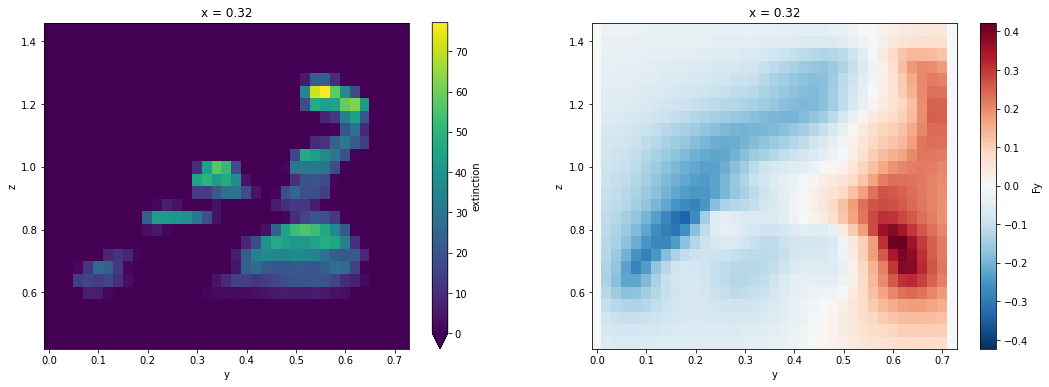

In [70]:
import pylab as py
fig,ax = py.subplots(1,2, figsize=(18,6))
solver.medium['cloud'].extinction.interp(x=0.32).T.plot(ax=ax[0],vmin=0.0)
solver.spherical_harmonics.Fy.interp(x=0.32).T.plot(ax=ax[1])

### Hemispherical Flux Output

We can also access the hemispherical and direct flux output from SHDOM and visualize the upwelling/downwelling fluxes

In [80]:
solver.fluxes

<xarray.Dataset>
Dimensions:      (x: 32, y: 37, z: 26)
Coordinates:
  * x            (x) float32 0.0 0.02 0.04 0.06 0.08 ... 0.54 0.56 0.58 0.6 0.62
  * y            (y) float32 0.0 0.02 0.04 0.06 0.08 ... 0.64 0.66 0.68 0.7 0.72
  * z            (z) float32 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    flux_down    (x, y, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flux_up      (x, y, z) float32 0.05015 0.05015 0.05015 ... 0.05015 0.05015
    flux_direct  (x, y, z) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    long_names:  {'flux_down': 'Downwelling Hemispherical Flux', 'flux_up': '...
    units:       Same units as input flux.

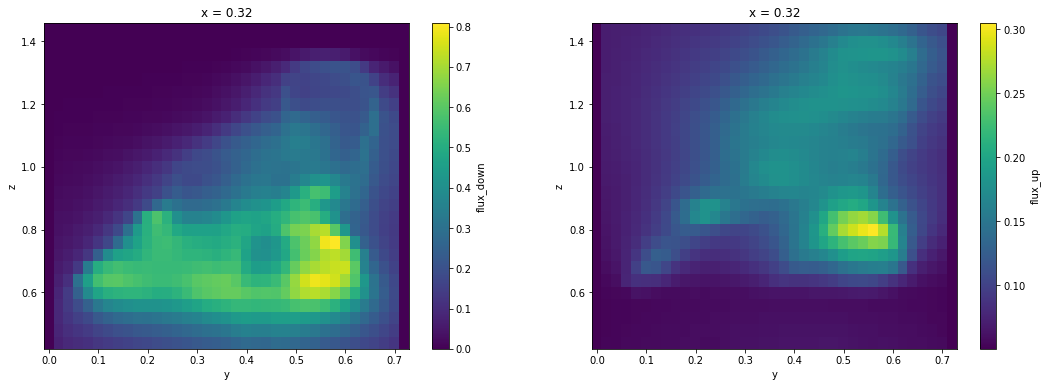

In [77]:
import pylab as py
fig,ax = py.subplots(1,2, figsize=(18,6))
#solver.medium['cloud'].extinction.interp(x=0.32).T.plot(ax=ax[0],vmin=0.0)
(solver.fluxes.flux_down).interp(x=0.32).T.plot(ax=ax[0])
solver.fluxes.flux_up.interp(x=0.32).T.plot(ax=ax[1])

### Net Flux Divergence

We can also access the net flux divergence output easily.

In [84]:
solver.net_flux_divergence

<xarray.Dataset>
Dimensions:       (x: 32, y: 37, z: 26)
Coordinates:
  * x             (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y             (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z             (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.32 1.36 1.4 1.44
Data variables:
    net_flux_div  (x, y, z) float32 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
Attributes:
    long_names:  {'net_flux_div': 'Net Flux Divergence'}
    units:

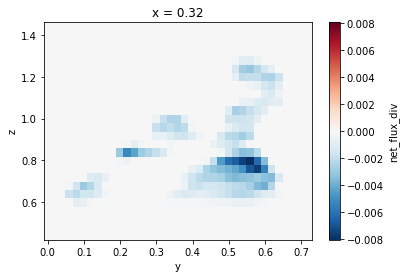

In [83]:
solver.net_flux_divergence.net_flux_div.interp(x=0.32).T.plot()